<a href="https://colab.research.google.com/github/ali1810/Deep_Chem/blob/main/cnn_solubility_Curateddatset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# general imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# keras imports
from keras.layers import (Input, Dense, Conv1D, MaxPool1D, Dropout, GRU, LSTM, 
                          TimeDistributed, Add, Flatten, RepeatVector, Lambda, Concatenate)
from keras.models import Model, load_model
from keras.metrics import binary_crossentropy
from keras import initializers
import keras.backend as K

# Visualization
#from keras_sequential_ascii import keras2ascii

# utils functions
#from utils import *

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Remove warnings from output
import warnings
warnings.filterwarnings('ignore')

In [11]:
## read dataset as a dataframe
dataset = pd.read_csv("/content/drive/MyDrive/curated-solubility-dataset.csv")

# print column names in dataset
print(f"Columns in dataset: {list(dataset.columns)}")

# print number of rows in dataset
print(f"\nLength of dataset: {len(dataset)}")

# shuffle rows of the dataset (we could do this later as well when doing train/test splits)
dataset = dataset.sample(frac=1, random_state=0)

# show first 5 rows of dataframe
dataset.head()

Columns in dataset: ['ID', 'Name', 'InChI', 'InChIKey', 'SMILES', 'Solubility', 'SD', 'Ocurrences', 'Group', 'MolWt', 'MolLogP', 'MolMR', 'HeavyAtomCount', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds', 'NumValenceElectrons', 'NumAromaticRings', 'NumSaturatedRings', 'NumAliphaticRings', 'RingCount', 'TPSA', 'LabuteASA', 'BalabanJ', 'BertzCT']

Length of dataset: 9982


,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,MolLogP,MolMR,HeavyAtomCount,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
6907,B-4206,diuron,InChI=1S/C9H10Cl2N2O/c1-13(2)9(14)12-6-3-4-7(1...,XMTQQYYKAHVGBJ-UHFFFAOYSA-N,CN(C)C(=O)Nc1ccc(Cl)c(Cl)c1,-3.744300,1.227164,5,G4,233.098,3.0869,59.1677,14.0,1.0,1.0,5.0,1.0,76.0,1.0,0.0,0.0,1.0,32.34,92.603980,2.781208,352.665233
9567,F-988,7-(3-amino-3-methylazetidin-1-yl)-8-chloro-1-c...,InChI=1S/C17H17ClFN3O3/c1-17(20)6-21(7-17)14-1...,DUNZFXZSFJLIKR-UHFFFAOYSA-N,CC1(N)CN(C2=C(Cl)C3=C(C=C2F)C(=O)C(C(=O)O)=CN3...,-5.330000,0.000000,1,G1,365.792,2.3645,93.2117,25.0,5.0,2.0,8.0,3.0,132.0,2.0,2.0,2.0,4.0,88.56,147.136366,2.001398,973.487509
8083,C-1996,4-acetoxybiphenyl; 4-biphenylyl acetate,InChI=1S/C14H12O2/c1-11(15)16-14-9-7-13(8-10-1...,MISFQCBPASYYGV-UHFFFAOYSA-N,CC(=O)OC1=CC=C(C=C1)C2=CC=CC=C2,-4.400000,0.000000,1,G1,212.248,3.2789,63.1870,16.0,2.0,0.0,2.0,2.0,80.0,2.0,0.0,0.0,2.0,26.30,94.493449,2.228677,471.848345
1861,A-3055,methane dimolybdenum,InChI=1S/CH4.2Mo/h1H4;;,JAGQSESDQXCFCH-UHFFFAOYSA-N,C.[Mo].[Mo],-3.420275,0.409223,2,G3,207.923,0.6311,6.7310,3.0,0.0,0.0,2.0,0.0,20.0,0.0,0.0,0.0,0.0,0.00,49.515427,-0.000000,2.754888
1509,A-2575,ethyl 4-[[(methylphenylamino)methylene]amino]b...,InChI=1S/C17H18N2O2/c1-3-21-17(20)14-9-11-15(1...,GNGYPJUKIKDJQT-UHFFFAOYSA-N,CCOC(=O)c1ccc(cc1)N=CN(C)c2ccccc2,-5.450777,0.000000,1,G1,282.343,3.6595,85.3955,21.0,3.0,0.0,4.0,5.0,108.0,2.0,0.0,0.0,2.0,41.90,124.243431,2.028889,606.447052


We can explore the range of solubilities found in the dataset by plotting a histogram of solubility values from the dataset. Our machine learning models will aim to predict these solubilities.

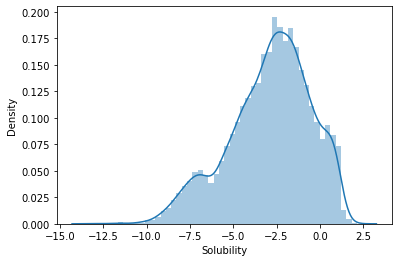

In [12]:
sns.distplot(dataset["Solubility"])

In the next cell we will plot a histogram of SMILES string lengths from dataset. These lengths will be used to determine the length of the inputs for our CNN model. Below are examples of the SMILES representation:

Methane: 'C' Pentane: 'CCCCC' Methanol and Ethanol: 'CO' and 'CCO' Pyridine: 'C1:C:C:N:C:C:1' To learn more about the SMILES representation, click here.

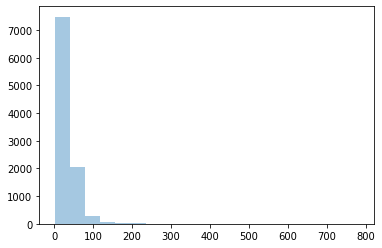

In [13]:
smiles_lengths = map(len, dataset.SMILES.values)
sns.distplot(list(smiles_lengths), bins=20, kde=False)

Data preparation Now we will pre-process the dataset for the CNN models. First, we'll get the unique character set from all SMILES strings in the dataset. Then we will use the unique character set to convert our SMILES strings to a one-hot representation, which is a representation that converts raw strings of text to numerical inputs for our models.

In a one-hot representation, each character of our SMILES string is encoded as a vector of zeros, except for one non-zero value. For instance, the character 'C' in the SMILES string is converted to a vector of length 31, consisting of 30 zeros and one non-zero entry of one. The length of this vector (31 in our case) is the total number of unique characters in the dataset.

Given a string of 5 characters (say Pentane, which is represented as 'CCCCC'), we would thus get 5 vectors each of length 31. Since different molecules have different SMILES string lengths, we can pre-define the length of each string to be the maximum length from the database, with smaller molecules represented with additional characters. In our case, this maximum length is 40 and we represent the extra characters for smaller molecules with pre-defined one-hot vectors. This means that each molecule is now represented as a set of 40 vectors, each of length 31. We can represent this as a 40x31 matrix.

One-hot encoding is commonly used in natural language processing, and you can learn more about one-hot encoding here.

Finally, we will define our input and output and create test/train splits in the dataset.

In [14]:
## Function to create unique character from string 

def generate_charset(full_char_list:list) -> list:
    '''
    Assumes full_char_list is a list of characters (e.g., ['c', 'c', '1']).
    Returns a sorted list of unique characters, with index zero as a NULL character, and a PAD character.
    '''
    unique_chars = set(''.join(full_char_list))
    charset = ['NULL', 'PAD'] + sorted(unique_chars)
    return charset

In [15]:
### Function to create one hot encoder ....

def smiles_to_onehots(smiles_strings:list,
                     unique_charset:list,
                     max_smiles_chars:int) -> np.array:
    one_hots = []
    charset_length = len(unique_charset)

    for smiles_string in smiles_strings:
        one_hot_smiles = np.zeros(shape=(max_smiles_chars, charset_length))
        for i in range(max_smiles_chars):
            one_hot_col = [0]*charset_length
            ind = None # Which index will we flip to be "one-hot"?
            
            if i < len(smiles_string):
                try:
                    ind = unique_charset.index(smiles_string[i])
                    # one_hot_col[unique_charset.index(char)] = 1
                except ValueError:
                    ind = 0 # Treat as NULL if out-of-vocab  
                    # one_hot_col[0] = 1 # Treat as NULL if out-of-vocab   
            else:
                ind = 1 # Add PAD as needed
            
            one_hot_col[ind] = 1
            one_hot_smiles[i,:] = one_hot_col
            
        one_hots.append(one_hot_smiles)
    return np.array(one_hots)

In [19]:
### Getting Max Character of the Smiles string ......

smiles_lengths = max(dataset1["SMILES"],key =len)
print(len(smiles_lengths))

49


In [17]:
###  Creating New SMILES column to reduce the feature of smiles ....

dataset["SMILES_LENGTH"]= dataset["SMILES"].apply(len)



In [18]:
#smiles_length = dataset["SMILES"],key =len
#print(smiles_length)
dataset1  = dataset[dataset['SMILES_LENGTH'] < 50]

In [ ]:
len(dataset1)

8511

In [ ]:
dataset.head()

,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,MolLogP,MolMR,HeavyAtomCount,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT,SMILES_NEW,SMILES_LENGTH
6907,B-4206,diuron,InChI=1S/C9H10Cl2N2O/c1-13(2)9(14)12-6-3-4-7(1...,XMTQQYYKAHVGBJ-UHFFFAOYSA-N,CN(C)C(=O)Nc1ccc(Cl)c(Cl)c1,-3.744300,1.227164,5,G4,233.098,3.0869,59.1677,14.0,1.0,1.0,5.0,1.0,76.0,1.0,0.0,0.0,1.0,32.34,92.603980,2.781208,352.665233,False,27
9567,F-988,7-(3-amino-3-methylazetidin-1-yl)-8-chloro-1-c...,InChI=1S/C17H17ClFN3O3/c1-17(20)6-21(7-17)14-1...,DUNZFXZSFJLIKR-UHFFFAOYSA-N,CC1(N)CN(C2=C(Cl)C3=C(C=C2F)C(=O)C(C(=O)O)=CN3...,-5.330000,0.000000,1,G1,365.792,2.3645,93.2117,25.0,5.0,2.0,8.0,3.0,132.0,2.0,2.0,2.0,4.0,88.56,147.136366,2.001398,973.487509,False,54
8083,C-1996,4-acetoxybiphenyl; 4-biphenylyl acetate,InChI=1S/C14H12O2/c1-11(15)16-14-9-7-13(8-10-1...,MISFQCBPASYYGV-UHFFFAOYSA-N,CC(=O)OC1=CC=C(C=C1)C2=CC=CC=C2,-4.400000,0.000000,1,G1,212.248,3.2789,63.1870,16.0,2.0,0.0,2.0,2.0,80.0,2.0,0.0,0.0,2.0,26.30,94.493449,2.228677,471.848345,False,31
1861,A-3055,methane dimolybdenum,InChI=1S/CH4.2Mo/h1H4;;,JAGQSESDQXCFCH-UHFFFAOYSA-N,C.[Mo].[Mo],-3.420275,0.409223,2,G3,207.923,0.6311,6.7310,3.0,0.0,0.0,2.0,0.0,20.0,0.0,0.0,0.0,0.0,0.00,49.515427,-0.000000,2.754888,False,11
1509,A-2575,ethyl 4-[[(methylphenylamino)methylene]amino]b...,InChI=1S/C17H18N2O2/c1-3-21-17(20)14-9-11-15(1...,GNGYPJUKIKDJQT-UHFFFAOYSA-N,CCOC(=O)c1ccc(cc1)N=CN(C)c2ccccc2,-5.450777,0.000000,1,G1,282.343,3.6595,85.3955,21.0,3.0,0.0,4.0,5.0,108.0,2.0,0.0,0.0,2.0,41.90,124.243431,2.028889,606.447052,False,33


In [ ]:
dataset.head()

,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,MolLogP,MolMR,HeavyAtomCount,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT,SMILES_NEW
6907,B-4206,diuron,InChI=1S/C9H10Cl2N2O/c1-13(2)9(14)12-6-3-4-7(1...,XMTQQYYKAHVGBJ-UHFFFAOYSA-N,CN(C)C(=O)Nc1ccc(Cl)c(Cl)c1,-3.744300,1.227164,5,G4,233.098,3.0869,59.1677,14.0,1.0,1.0,5.0,1.0,76.0,1.0,0.0,0.0,1.0,32.34,92.603980,2.781208,352.665233,False
9567,F-988,7-(3-amino-3-methylazetidin-1-yl)-8-chloro-1-c...,InChI=1S/C17H17ClFN3O3/c1-17(20)6-21(7-17)14-1...,DUNZFXZSFJLIKR-UHFFFAOYSA-N,CC1(N)CN(C2=C(Cl)C3=C(C=C2F)C(=O)C(C(=O)O)=CN3...,-5.330000,0.000000,1,G1,365.792,2.3645,93.2117,25.0,5.0,2.0,8.0,3.0,132.0,2.0,2.0,2.0,4.0,88.56,147.136366,2.001398,973.487509,False
8083,C-1996,4-acetoxybiphenyl; 4-biphenylyl acetate,InChI=1S/C14H12O2/c1-11(15)16-14-9-7-13(8-10-1...,MISFQCBPASYYGV-UHFFFAOYSA-N,CC(=O)OC1=CC=C(C=C1)C2=CC=CC=C2,-4.400000,0.000000,1,G1,212.248,3.2789,63.1870,16.0,2.0,0.0,2.0,2.0,80.0,2.0,0.0,0.0,2.0,26.30,94.493449,2.228677,471.848345,False
1861,A-3055,methane dimolybdenum,InChI=1S/CH4.2Mo/h1H4;;,JAGQSESDQXCFCH-UHFFFAOYSA-N,C.[Mo].[Mo],-3.420275,0.409223,2,G3,207.923,0.6311,6.7310,3.0,0.0,0.0,2.0,0.0,20.0,0.0,0.0,0.0,0.0,0.00,49.515427,-0.000000,2.754888,False
1509,A-2575,ethyl 4-[[(methylphenylamino)methylene]amino]b...,InChI=1S/C17H18N2O2/c1-3-21-17(20)14-9-11-15(1...,GNGYPJUKIKDJQT-UHFFFAOYSA-N,CCOC(=O)c1ccc(cc1)N=CN(C)c2ccccc2,-5.450777,0.000000,1,G1,282.343,3.6595,85.3955,21.0,3.0,0.0,4.0,5.0,108.0,2.0,0.0,0.0,2.0,41.90,124.243431,2.028889,606.447052,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3719,B-99,dieldrin,InChI=1S/C12H8Cl6O/c13-8-9(14)11(16)5-3-1-2(6-...,DFBKLUNHFCTMDC-UHFFFAOYSA-N,ClC1=C(Cl)C2(Cl)C3C4CC(C5OC45)C3C1(Cl)C2(Cl)Cl,-6.290800,0.069177,3,G5,380.913,4.4814,77.5750,19.0,1.0,0.0,7.0,0.0,104.0,0.0,4.0,5.0,5.0,12.53,139.967998,1.802907,516.422862,False
1231,A-2131,"Benzenamine, N-phenyl-, styrenated",InChI=1S/C28H27N/c1-21(23-9-5-3-6-10-23)25-13-...,BRWSDEFCJGIRLV-UHFFFAOYSA-N,CC(c1ccccc1)c2ccc(Nc3ccc(cc3)C(C)c4ccccc4)cc2,-5.964169,0.000000,1,G1,377.531,7.7338,124.0847,29.0,1.0,1.0,1.0,6.0,144.0,4.0,0.0,0.0,4.0,12.03,173.612316,1.428792,932.165538,False
9034,F-180,2-[(2-amino-4-methylpentanoyl)amino]-4-methylp...,InChI=1S/C12H24N2O3/c1-7(2)5-9(13)11(15)14-10(...,LCPYQJIKPJDLLB-UHFFFAOYSA-N,CC(C)CC(N)C(=O)NC(CC(C)C)C(=O)O,-0.690000,0.000000,1,G1,244.335,0.9753,66.4519,17.0,3.0,3.0,5.0,7.0,100.0,0.0,0.0,0.0,0.0,92.42,102.760645,4.345632,264.476356,False
3613,A-6047,"2,2'-[[4-[(3,5-dinitro-2-thienyl)azo]phenyl]im...",InChI=1S/C18H19N5O8S/c1-12(24)30-9-7-21(8-10-3...,YPNBSXJSFUWYMV-UHFFFAOYSA-N,CC(=O)OCCN(CCOC(C)=O)c1ccc(cc1)N=Nc2sc(cc2[N+]...,-7.547294,0.000000,1,G1,465.444,3.9125,113.7248,32.0,12.0,0.0,14.0,11.0,170.0,2.0,0.0,0.0,2.0,166.84,185.111095,2.142720,1000.877400,False


In [23]:
# get unique character set in all SMILES strings 
charset = generate_charset(dataset1["SMILES"].values.ravel())

# get the number of unique characters
charset_length = len(charset)
print(charset_length)

# define max number of SMILES for model input vector
max_smiles_chars = 49

# dimension of input vector
input_dim = charset_length * max_smiles_chars

# get one-hot representation of the SMILES strings 
one_hots = smiles_to_onehots(dataset1["SMILES"].values, charset, max_smiles_chars)

# split input into train and test sets
X_train = one_hots[:-100]
X_test = one_hots[-100:]

# split output to train and test sets
output = dataset1["Solubility"].values
Y_train = output[:-100]
Y_test = output[-100:]

61


In [60]:
type(one_hots) 
#type(new_df)
one_hots.shape
#new_df.shape 
#df = pd.DataFrame(one_hots)
### Comining in single dataframe ...  
### To make X matrix 
#age_sex = titanic[["Age", "Sex"]]
#new_df=dataset1[["MolWt",	"MolLogP"]]
#print(new_df)
#X = pd.concat([X_train,new_df], axis=1)
#X

(8511, 49, 61)

In [64]:
#df = pd.DataFrame(data=one_hots, index=None, columns=None)
#df = pd.DataFrame(one_hots[:,0,0])
#df
#df = pd.Panel(one_hots).to_frame()
#print (df)

#arr = one_hots.transpose(0,1,2)
#df = pd.concat([pd.DataFrame(x) for x in arr], keys=np.arange(arr.shape[2]))
#print (df)
   

In [38]:
df1 = new_df.set_index(new_df.groupby(level=0).cumcount(), append=True)
df2 = one_hots.set.set_index(X_train.groupby(level=0).cumcount(), append=True)
df = pd.concat([df1, df2], axis=1, ignore_index=True).reset_index(drop=True, level=1)

AttributeError: ignored

In [ ]:
### Now we can have look for the input data ....
X_train_length = len(X_train)
X_test_length = len(X_test)
Y_train_length = len(Y_train)
Y_test_length = len(Y_test)

print(" Numebr of X_train data ::",X_train_length)
print(" Numebr of X_test data ::",X_test_length)
print(" Numebr of Y_train data ::",Y_train_length)
print(" Numebr of Y_test data ::",Y_test_length)


 Numebr of X_train data :: 8411
 Numebr of X_test data :: 100
 Numebr of Y_train data :: 8411
 Numebr of Y_test data :: 100


[Na+].[Na+].[O-][S](=O)(=O)c1ccc2c(C=CC(=O)/C2=N/Nc3ccc(N=Nc4ccc(Nc5ccccc5)c(c4)[S]([O-])(=O)=O)c6ccccc36)c1


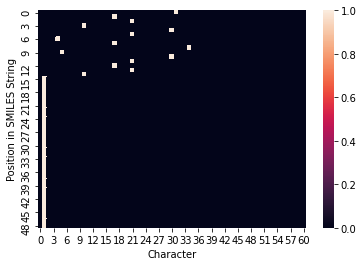

In [ ]:
### Visulaization of one hot encoder string as SMILES 
index = 7221
sns.heatmap(X_train[index]) # This is a single training example -- note that it is a matrix, not a single vector!
plt.xlabel('Character')
plt.ylabel('Position in SMILES String')
print(dataset.iloc[index]['SMILES'])

Supervised CNN model for predicting solubility In this section, we will set up a convolutional neural network to predict solubility using one-hot SMILES as input. A convolutional neural network is a machine learning model that is commonly used to classify images, and you can learn more about them here.

Define model structure First, we will create the model structure, starting with the input layer. As described above, each training example is a 783x65 matrix, which is the shape we pass to the Input layer in Keras.

In [ ]:
# Define the input layer
# NOTE: We feed in a sequence here! We're inputting up to max_smiles_chars characters, 
# and each character is an array of length charset_length
smiles_input = Input(shape=(max_smiles_chars, charset_length), name="SMILES-Input")

In [ ]:
## Shape of the input layer ....
smiles_input.shape

TensorShape([None, 49, 61])

**Next we will define the convolution layers where each layer attempts to learn certain features of the images, such as edges and corners. The input to each layer (a matrix) is transformed via convolution operations, which are element by element multiplications of the input matrix and a filter matrix. The convolutional layer learns the filter matrix that will best identify unique features of the image. You can learn more about convolution operations and the math behind convolutional neural networks here.**



In [ ]:
# Set parameters for convolutional layers 
num_conv_filters = 16
kernel_size = 3

init_weights = initializers.glorot_normal(seed=0)

# Define the convolutional layers
# Multiple convolutions in a row is a common architecture (but there are many "right" choices here)
conv_1_func = Conv1D(
    filters=num_conv_filters, # What is the "depth" of the convolution? How many times do you look at the same spot?
    kernel_size=kernel_size, # How "wide" of a spot does each filter look at?
    name="Convolution-1",
    activation="relu", # This is a common activation function: Rectified Linear Unit (ReLU)
    kernel_initializer=init_weights #This defines the initial values for the weights
)
conv_2_func = Conv1D(
    filters=num_conv_filters, 
    kernel_size=kernel_size, 
    name="Convolution-2",
    activation="relu",
    kernel_initializer=init_weights
)
conv_3_func = Conv1D(
    filters=num_conv_filters, 
    kernel_size=kernel_size, 
    name="Convolution-3",
    activation="relu",
    kernel_initializer=init_weights
)
conv_4_func = Conv1D(
    filters=num_conv_filters, 
    kernel_size=kernel_size,
    name="Convolution-4",
    activation="relu",
    kernel_initializer=init_weights
)



The four convolution layers defined above will attempt to learn features of the SMILES string (represented as a 783x65 matrix) that are relevant to predicting the solubility. To get a numerical prediction, we now flatten the output of the convolution and pass it to a set of regular Dense layers, the last layer predicting one value for the solubility.

In [ ]:
# Define layer to flatten convolutions
flatten_func = Flatten(name="Flattened-Convolutions")

# Define the activation function layer
hidden_size = 32
dense_1_func = Dense(hidden_size, activation="relu", name="Fully-Connected", kernel_initializer=init_weights)

# Define output layer -- it's only one dimension since it is regression
output_size = 1
output_solubility_func = Dense(output_size, activation="linear", name="Log-Solubility", kernel_initializer=init_weights)

In [ ]:
# connect the CNN graph together
conv_1_fwd = conv_1_func(smiles_input)
conv_2_fwd = conv_2_func(conv_1_fwd)
conv_3_fwd = conv_3_func(conv_2_fwd)
conv_4_fwd = conv_4_func(conv_3_fwd)
flattened_convs = flatten_func(conv_4_fwd)
dense_1_fwd = dense_1_func(flattened_convs)
output_solubility_fwd = output_solubility_func(flattened_convs)

View model structure and metadata Now the model is ready to train! But first we will define the model as solubility_model and compile it, then view some information on the model using the keras2ascii tool, which visually represents the layers in our model.

In [ ]:
# create model
solubility_model = Model(
            inputs=[smiles_input],
            outputs=[output_solubility_fwd]
)

# compile model
solubility_model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

Train CNN Now we will train our CNN solubility model to the training data! During training, we will see metrics printed after each epoch such as test/train loss (both as Mean Squared Error (MSE) and Mean Absolute Error (MAE)).



In [1]:
history = solubility_model.fit(
    X_train, # Inputs
    Y_train, # Outputs
    epochs=100, # How many times to pass over the data
    batch_size=32, # How many data rows to compute at once
    verbose=1,
    validation_data=(X_test, Y_test), # You would usually use more splits of the data if you plan to tune hyperparams
)

NameError: ignored

Let's view the learning curve for the trained model.

This code will generate a plot where we show the test and train errors (MSE) as a function of epoch (one pass of all training examples through the NN).

The learning curve will tell us if the model is overfitting or underfitting.

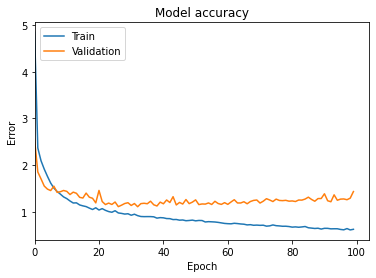

In [ ]:
# plot the learning curve 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.xlim(0,)
plt.legend(['Train', 'Validation',], loc='upper left')
plt.show()

Use CNN to make solubility predictions Now that we've trained our model, we can use it to make solubility predictions for any SMILES string! We just have to convert the SMILES string to 1-hot representation, then feed it to the solubility_model



In [ ]:
example_smiles = [
    'CC12CCC3C4:C:C:C(O):C:C:4CCC3C1CCC2O',
    'CC1:O:C:C:C:1C(=O)NC1:C:C:C:C:C:1',
    'C1:C:C:C2:C(:C:1):C:C:C1:C:2:C:C:C2:C3:C:C:C:C:C:3:C:C:C:2:1'
]

for smiles in example_smiles:
    predict_test_input = smiles_to_onehots([smiles], charset, max_smiles_chars)
    solubility_prediction = solubility_model.predict(predict_test_input)[0][0]
    print(f'The predicted log solubility for SMILES {smiles} is {solubility_prediction}')

The predicted log solubility for SMILES CC12CCC3C4:C:C:C(O):C:C:4CCC3C1CCC2O is -3.074120044708252
The predicted log solubility for SMILES CC1:O:C:C:C:1C(=O)NC1:C:C:C:C:C:1 is -2.7483432292938232
The predicted log solubility for SMILES C1:C:C:C2:C(:C:1):C:C:C1:C:2:C:C:C2:C3:C:C:C:C:C:3:C:C:C:2:1 is -4.840444087982178


We can now make a parity plot comparing the CNN model predictions to the ground truth data



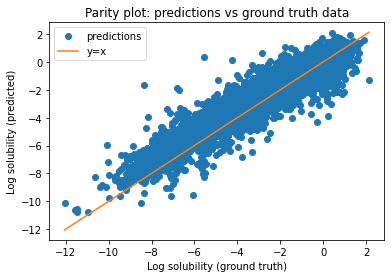

In [ ]:
preds = solubility_model.predict(X_train)
x_y_line = np.linspace(min(Y_train.flatten()), max(Y_train.flatten()), 500)
plt.plot(Y_train.flatten(), preds.flatten(), 'o', label='predictions')
plt.plot(x_y_line, x_y_line, label='y=x')
plt.xlabel("Log solubility (ground truth)")
plt.ylabel("Log solubility (predicted)")
plt.title("Parity plot: predictions vs ground truth data")
plt.legend()

In [2]:
### Comparartive prediction of y_test and y_test predicted .....
Y_test_predited=solubility_model.predict(X_test)
#print(Y_test_predited)

print(np.concatenate((Y_test_predited.reshape(len(Y_test_predited),1), Y_test.reshape(len(Y_test),1)),1))

NameError: ignored

In [ ]:
from sklearn.metrics import r2_score
r2_score(Y_test, Y_test_predited)

0.6777349439571112